In [1]:
# load libraries needed
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

books = pd.read_csv('./data/Books.csv', low_memory = False)
rating = pd.read_csv('./data/Ratings.csv', low_memory = False)
users = pd.read_csv('./data/Users.csv', low_memory = True)

# drop unnecessary columns
books.drop(axis=1, labels=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)

df = rating.merge(books, how='inner', on='ISBN')
df = df.merge(users, how='inner', on='User-ID')

# drop NaN values
df.dropna(inplace=True)

# df = df.drop(['User-ID'],axis=1)

In [3]:
# extra cleaning for dirty data
#bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
#ISBN '0789466953'
df.loc[df.ISBN == '0789466953','Year-Of-Publication'] = 2000
df.loc[df.ISBN == '0789466953','Book-Author'] = "James Buckley"
df.loc[df.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
df.loc[df.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

#ISBN '078946697X'
df.loc[df.ISBN == '078946697X','Year-Of-Publication'] = 2000
df.loc[df.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
df.loc[df.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
df.loc[df.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

#rechecking
df.loc[(df.ISBN == '0789466953') | (df.ISBN == '078946697X'),:]

df.loc[df.ISBN == '2070426769','Year-Of-Publication'] = 2003
df.loc[df.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
df.loc[df.ISBN == '2070426769','Publisher'] = "Gallimard"
df.loc[df.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"

df.loc[df.ISBN == '2070426769',:]

df = df.drop(['ISBN'],axis=1)

In [4]:
le = LabelEncoder()
df['Book-Title'] = le.fit_transform(df['Book-Title'])
df['Book-Author'] = le.fit_transform(df['Book-Author'])
df['Publisher'] = le.fit_transform(df['Publisher'])
df['Location'] = le.fit_transform(df['Location'])

df

,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
1,2313,5,57818,53017,2002,1207,2943,23.0
2,2313,9,51670,63275,1986,12909,2943,23.0
3,2313,8,77319,80306,1994,13558,2943,23.0
4,2313,9,45163,69139,1996,5779,2943,23.0
5,2313,5,168860,13190,1998,639,2943,23.0
...,...,...,...,...,...,...,...,...
1031130,276442,6,85581,23870,2001,4058,5280,62.0
1031131,276442,7,89014,46306,2002,7394,5280,62.0
1031133,276647,0,29962,48440,2001,12214,586,13.0
1031134,276647,10,69602,3591,1998,11866,586,13.0


In [5]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y= None,None,None,None
# train_x, test_x, train_y, test_y = train_test_split(df.drop(['Book-Rating'],axis=1),
#     df['Book-Rating'],random_state=42,train_size=0.8,test_size=0.2,shuffle=True)
train_x, test_x, train_y, test_y = train_test_split(df,
    df['Book-Rating'],random_state=42,train_size=0.8,test_size=0.2,shuffle=True)

In [6]:
# svm is slow so we're throwing out data
keep_percentage = 0.1  # Keeping 10%

num_samples = len(train_x)
num_samples_to_keep = int(num_samples * keep_percentage)

random_indices_to_keep = np.random.choice(num_samples, num_samples_to_keep, replace=False)

# Filter the data based on random indices using iloc
train_x = train_x.iloc[random_indices_to_keep]
train_y = train_y.iloc[random_indices_to_keep]


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Scaling the data
scaler = StandardScaler()
scaler.fit(train_x)
train_x_scaled = scaler.transform(train_x)
test_x_scaled = scaler.transform(test_x)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import csr_matrix

book_sparse=csr_matrix(train_x_scaled)
model=NearestNeighbors(algorithm='brute')
model.fit(book_sparse)

NearestNeighbors(algorithm='brute')

In [9]:
distances,suggestions=model.kneighbors(train_x.iloc[237,:].values.reshape(1,-1),n_neighbors=6)

In [10]:
distances, suggestions = model.kneighbors(train_x.iloc[237, :].values.reshape(1, -1), n_neighbors=6)

# Now, use a classifier (e.g., KNeighborsClassifier) for prediction on the test set
knn_classifier = KNeighborsClassifier(n_neighbors=6)
knn_classifier.fit(train_x_scaled, train_y)  # Assuming train_y contains labels for train_x

# Predict labels for the test set using the classifier
predicted_labels = knn_classifier.predict(test_x_scaled)

In [11]:
predicted_labels = knn_classifier.predict(test_x_scaled)

# Calculate evaluation metrics using the predicted_labels and test_y
results_dict = {
    'Accuracy': accuracy_score(test_y, predicted_labels),
    'Precision': precision_score(test_y, predicted_labels, average='macro'),
    'Recall': recall_score(test_y, predicted_labels, average='macro')
}
results_dict

{'Accuracy': 0.8122195672374883,
 'Precision': 0.40082210670131374,
 'Recall': 0.357462403596686}

/Users/savan/opt/anaconda3/envs/cis477/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/savan/opt/anaconda3/envs/cis477/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/savan/opt/anaconda3/envs/cis477/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/savan/opt/anaconda3/envs/cis477/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/savan/opt/anaconda3/envs/cis477/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/savan/op

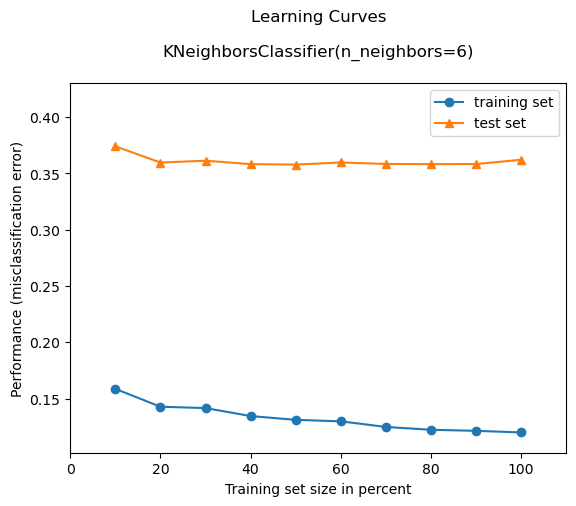

In [12]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt

# Plotting learning curve
plot_learning_curves(X_test=test_x, y_test=test_y, clf=knn_classifier, X_train=train_x_scaled, y_train=train_y)
plt.show()